In [3]:
%run './model/multi_corpus.py'
%run './model/ergm_functions.py'
%run './constants.py'

sns.set(rc = {'figure.figsize':(15,8)})

import multiprocessing as mp
import polars as pl
from itertools import combinations
# mp.set_start_method('forkserver')
import math

import networkx as nx

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp

from itertools import product
from scipy.special import comb
from sklearn.preprocessing import MinMaxScaler

import os

from scipy.spatial.distance import cosine
from scipy.stats import norm

import pytensor.tensor as pt

from IPython.display import display

# RANDOM_SEED = 8927
# rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
corpora = co_citation_graphs(n_edges=10)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 12 nodes and 10 edges
Geometry Graph with 15 nodes and 10 edges
Geophysics Graph with 14 nodes and 10 edges
Economics Graph with 12 nodes and 10 edges
Language & Linguistics Graph with 13 nodes and 10 edges
Probability & Statistics Graph with 9 nodes and 10 edges
Material Engineering Graph with 15 nodes and 10 edges
Artificial Intelligence Graph with 15 nodes and 10 edges
Sociology Graph with 8 nodes and 10 edges
International Business Graph with 10 nodes and 10 edges
Political Science Graph with 19 nodes and 10 edges
Genetics & Genomics Graph with 12 nodes and 10 edges
Immunology Graph with 16 nodes and 10 edges
Human Resources & Organizations Graph with 16 nodes and 10 edges
Ethnic & Cultural Studies Graph with 15 nodes and 10 edges
Neurology Graph with 15 nodes and 10 edges


In [5]:
tables = []
dist = {}

for (field_name, d) in corpora.items():

    print(field_name)

    G = d['G']
    df = d['Df']

    observed = nx.to_numpy_array(G, weight=None)

    βs_xs = {
        'Density': delta_edges(G),
        # 'Triangles': delta_triangles(G),
        # 'Stars': delta_star(G, 3),
        # 'Betweenness': delta_betweenness(G),
        # 'Closeness': delta_closeness(G),
        # 'Eigenvector': delta_eigenvector(G),
        'Centralization': delta_centralization(G),
        # 'Clustering': delta_clustering(G),
        # 'Transitivity': delta_transitivity(G),
        # 'Cliques': delta_cliques(G),
        # 'Components': delta_components(G),
        # 'Gini': delta_gini(G),
        'Louvain': delta_louvain(G),
        # 'Date': date(G, df, 5)
        # 'Geodesic': delta_geodesic(G),
    }

    dist[field_name] = βs_xs

    with pm.Model() as model:

        βs = []
        xs = []
        for β_name, x in βs_xs.items():
            β = pm.Normal(β_name, sigma=1, initval=None)
            βs.append(β)
            xs.append(x)

        μ = sum(β * x for β, x in zip(βs, xs))

        # likelihood = pm.math.sigmoid(μ)
        likelihood = pm.math.exp(μ)

        pm.Bernoulli(name='logit', p=likelihood, observed=observed)

        trace = pm.sample(
            tune=1000,
            draws=2000,
            chains=4,
            # init = 'adapt_diag',
            cores=4,
            # step=pm.Metropolis(),
            step=pm.NUTS(),
            # random_seed=12345,
        )

        trace.to_netcdf(os.path.join(os.path.join(OUTPUT_PATH, f'co_citation_traces'), f'{field_name}.nc'))


Gender Studies


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Density': array(0.), 'Centralization': array(0.), 'Louvain': array(0.)}

Initial evaluation results:
{'Density': -0.92, 'Centralization': -0.92, 'Louvain': -0.92, 'logit': -inf}

# Table

In [7]:
def p_value_stars(p_value):
    match p_value:
        case _ if p_value <= 0.001:
            stars = '***'
        case _ if p_value <= 0.01:
            stars =  '**'
        case _ if p_value <= 0.05:
            stars =  '*'  
        case _:
            stars = ' '
    return stars

In [8]:
traces_path = os.path.join(OUTPUT_PATH, f'co_citation_traces')

co_citation_coef = []
co_citation_se = []

for file in os.listdir(traces_path):

    field_name = file.split('.')[0]
    trace = az.from_netcdf(os.path.join(traces_path, file))

    summary = az.summary(trace, kind="stats")
    summary.index.name = 'beta'
    df = pl.from_pandas(summary, include_index=True)
    df = df.with_columns(pl.col('beta').str.replace('_', ' '))

    df = (
        df
        .with_columns((pl.col('mean') / pl.col('sd')).round(4).alias('z_score'))
        .with_columns((pl.col('z_score').abs().apply(norm.sf).round(4).alias('p_value')))
        .with_columns(pl.col('p_value').apply(p_value_stars).alias('significance'))
    )

    df_coef = (
        df.select(
            pl.col('beta'),
            pl.concat_str(
                [
                    pl.col('mean'),
                    pl.col('significance')
                ],
                # sep=''
            ).alias(field_name),
        )
    )

    df_se = (
        df.select(
            pl.col('beta'),
            pl.concat_str(
                [
                    pl.lit('('),
                    pl.col('sd'),
                    pl.lit(')'),
                ]
            ).alias(field_name),
        )
    )

    co_citation_coef.append(df_coef)
    co_citation_se.append(df_se)

iter_dfs = iter(co_citation_coef)
co_citation_df_coef = next(iter_dfs)
for df in iter_dfs:
    co_citation_df_coef = co_citation_df_coef.join(df, on='beta', how='inner')

iter_dfs = iter(co_citation_se)
co_citation_df_se = next(iter_dfs)
for df in iter_dfs:
    co_citation_df_se = co_citation_df_se.join(df, on='beta', how='inner')

columns = sorted(co_citation_df_coef.select(pl.all().exclude('beta')).columns)

In [9]:
coef_df = co_citation_df_coef.select(pl.concat_str(pl.all(), sep=' & ').alias('all_fields'))
se_df = co_citation_df_se.select(pl.concat_str(pl.all().exclude('beta').alias('all_fields'), sep=' & '))

coef_df = coef_df['all_fields'].to_list()
se_df = se_df['all_fields'].to_list()

row_str = ''
for i in range(len(se_df)):
    row_str += f'{coef_df[i]} \\\ \n & {se_df[i]} \\\ \n \\addlinespace[0.5em] \n'

alignments = ''.join(['c']*len(columns)*2)

new_columns = []
for col in columns:
    if ' & ' in col:
        first, second = col.split(' & ')
        s = f'\\begin{{tabular}}{{cc}} {first} \& \\\ {second} \\end{{tabular}}'
        new_columns.append(s)
    elif ' ' in col:
        first, second = col.split(' ')
        s = f'\\begin{{tabular}}{{cc}} {first} \\\ {second} \\end{{tabular}}'
        new_columns.append(s)
    else:
        s = f'\\begin{{tabular}}{{cc}} {col} \\end{{tabular}}'
        new_columns.append(s)
new_columns = ' \n& '.join(new_columns)


table_str = f"""
\\begin{{tabular}}{{l*{{{len(columns)*2}}}{{c}}}}
\\toprule
\\addlinespace[0.7em]
& {new_columns} \\\ 
\\midrule
\\midrule
\\addlinespace[0.5em]
{row_str}
\\bottomrule
\end{{tabular}}
"""

with open(os.path.join(LATEX_TABLE_PATH, 'co_citation_ergm_model.tex'), "w+") as file:
    file.write(table_str)

In [10]:
print(table_str)


\begin{tabular}{l*{32}{c}}
\toprule
\addlinespace[0.7em]
& \begin{tabular}{cc} Artificial \\ Intelligence \end{tabular} 
& \begin{tabular}{cc} Economics \end{tabular} 
& \begin{tabular}{cc} Ethnic \& \\ Cultural Studies \end{tabular} 
& \begin{tabular}{cc} Gender \\ Studies \end{tabular} 
& \begin{tabular}{cc} Genetics \& \\ Genomics \end{tabular} 
& \begin{tabular}{cc} Geometry \end{tabular} 
& \begin{tabular}{cc} Geophysics \end{tabular} 
& \begin{tabular}{cc} Human Resources \& \\ Organizations \end{tabular} 
& \begin{tabular}{cc} Immunology \end{tabular} 
& \begin{tabular}{cc} International \\ Business \end{tabular} 
& \begin{tabular}{cc} Language \& \\ Linguistics \end{tabular} 
& \begin{tabular}{cc} Material \\ Engineering \end{tabular} 
& \begin{tabular}{cc} Neurology \end{tabular} 
& \begin{tabular}{cc} Political \\ Science \end{tabular} 
& \begin{tabular}{cc} Probability \& \\ Statistics \end{tabular} 
& \begin{tabular}{cc} Sociology \end{tabular} \\ 
\midrule
\midrule
\addli

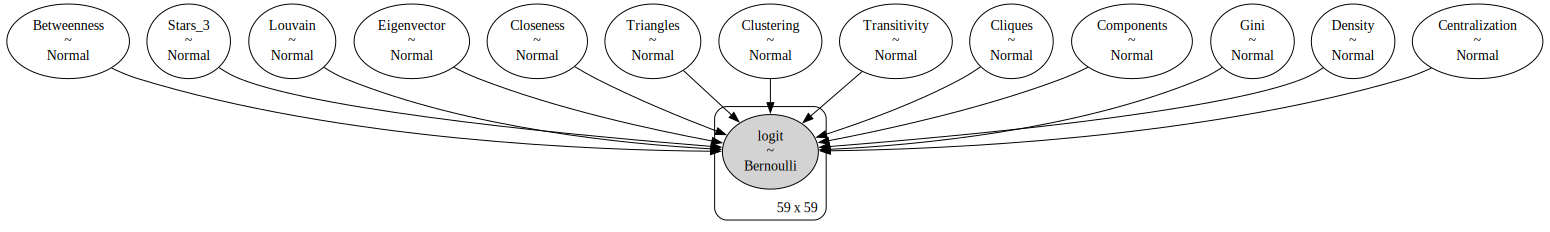

In [8]:
pm.model_to_graphviz(model)

In [5]:
dfs = []

for field_name, features in dist.items():
    df = pl.DataFrame()
    for feature_name, mat in features.items():
        df = df.with_columns(
            pl.Series(
                feature_name,
                mat.reshape(np.multiply(*mat.shape))
            )
        )
    df = df.with_columns(
        pl.Series(
            'Field',
            np.full((len(df)), field_name)
        )
    )
    dfs.append(df)
df = pl.concat(dfs)

# Univariate

[]

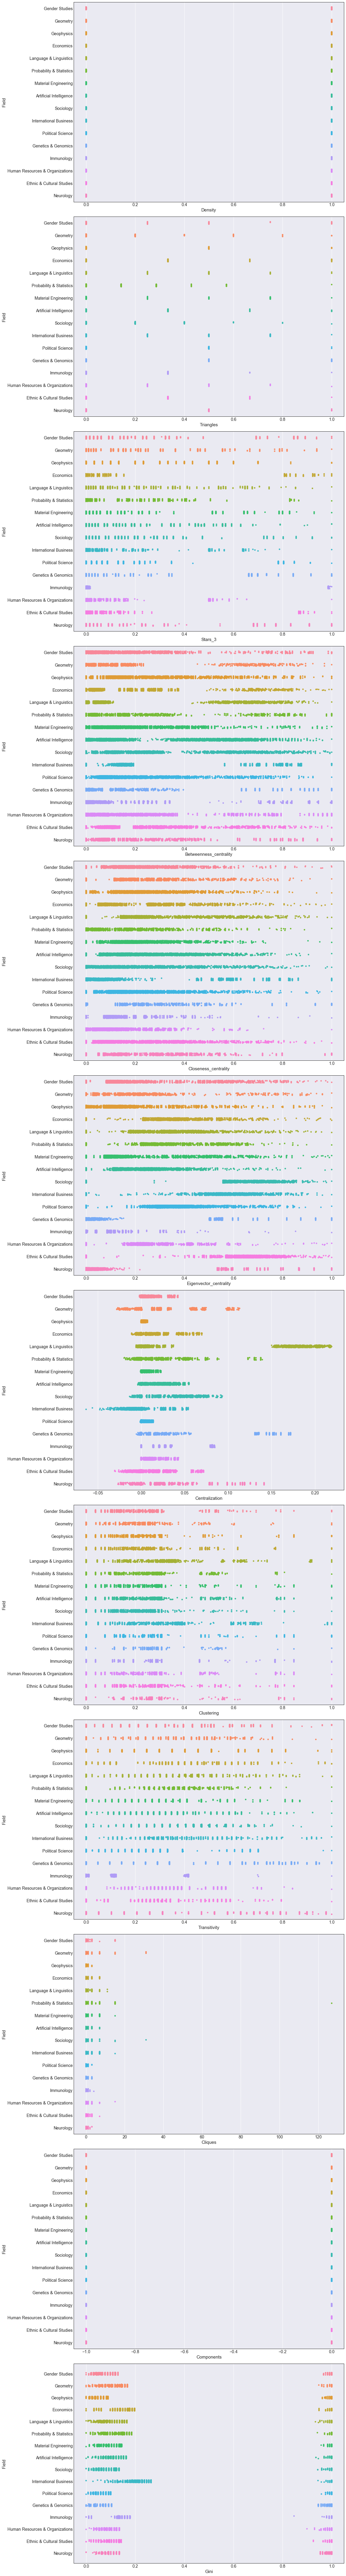

In [9]:
cols = df.select(pl.all().exclude('Field')).columns
n_cols = len(cols)

fig, axs = plt.subplots(n_cols, figsize=(16, 10*n_cols))
for col, ax in zip(cols, axs):
    sns.stripplot(data=df.to_pandas(), x=col, y="Field", ax=ax)
    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

plt.plot()

# Bivariate

In [23]:
df.to_pandas().corr()

,Density,Triangles,Stars_3,Betweenness_centrality,Closeness_centrality,Eigenvector_centrality,Centralization,Clustering,Transitivity,Cliques,Components,Gini
Density,1.000000,0.160574,0.313840,0.526416,0.692156,0.687221,0.261833,0.869309,0.878682,0.078952,-0.869119,0.117384
Triangles,0.160574,1.000000,0.089202,-0.048956,-0.032739,0.074621,-0.047601,0.411973,0.296057,0.582695,0.136496,0.026421
Stars_3,0.313840,0.089202,1.000000,0.313816,0.529547,0.482028,0.284984,0.241998,0.129628,0.077483,-0.276861,0.666678
Betweenness_centrality,0.526416,-0.048956,0.313816,1.000000,0.742312,0.563030,0.696748,0.358874,0.398722,-0.022046,-0.563525,0.166646
Closeness_centrality,0.692156,-0.032739,0.529547,0.742312,1.000000,0.659279,0.561288,0.510038,0.511891,-0.018701,-0.722024,0.214744
Eigenvector_centrality,0.687221,0.074621,0.482028,0.563030,0.659279,1.000000,0.319897,0.536097,0.527411,0.039930,-0.558162,0.226927
Centralization,0.261833,-0.047601,0.284984,0.696748,0.561288,0.319897,1.000000,0.184594,0.153985,-0.023455,-0.319692,0.216586
Clustering,0.869309,0.411973,0.241998,0.358874,0.510038,0.536097,0.184594,1.000000,0.814630,0.171850,-0.657959,0.127810
Transitivity,0.878682,0.296057,0.129628,0.398722,0.511891,0.527411,0.153985,0.814630,1.000000,0.165506,-0.696959,0.002392
Cliques,0.078952,0.582695,0.077483,-0.022046,-0.018701,0.039930,-0.023455,0.171850,0.165506,1.000000,0.067113,0.013298


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


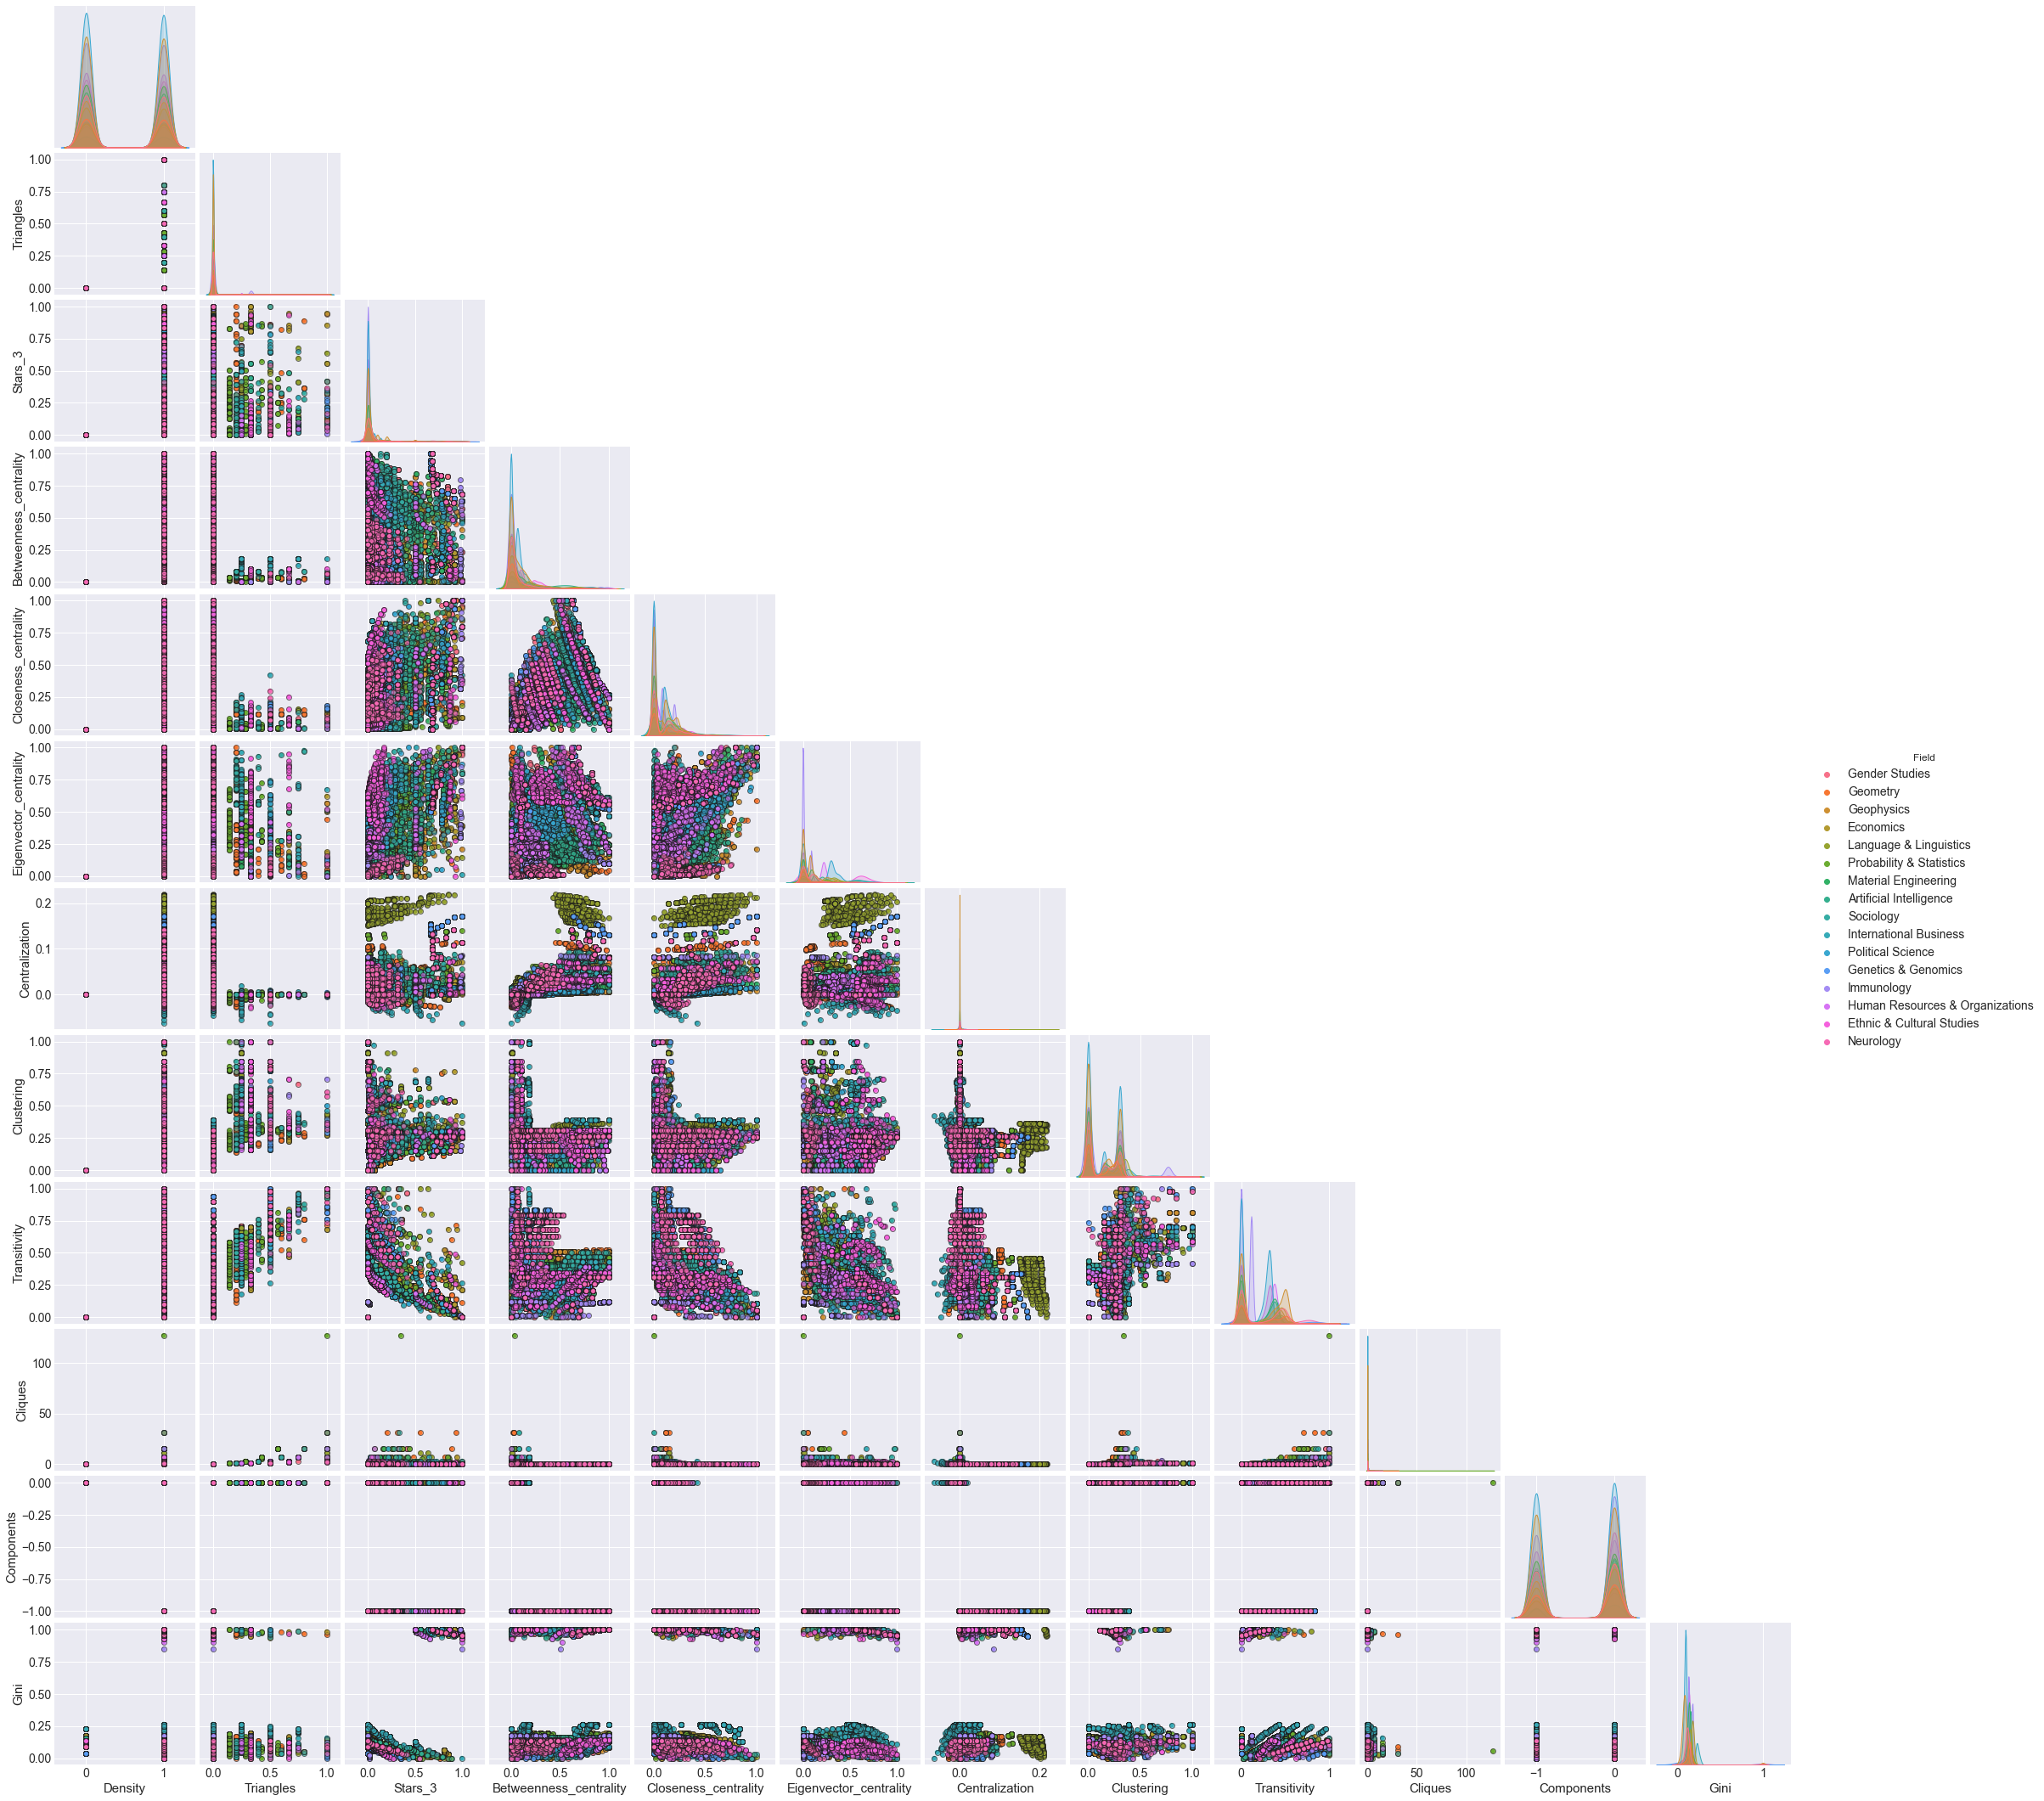

In [12]:
# sns.set(rc={'figure.figsize':(16, 12)})
sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor': 'black', 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True})

pp = sns.pairplot(df.to_pandas(), vars=None, hue='Field', corner=True, grid_kws={'layout_pad': 0.5}) # , corner=True , grid_kws={"despine": False}

pp.map_lower(plt.scatter, alpha = 0.6, linewidth=1, edgecolor='k')

# pp.map_lower(sns.scatterplot)
# g.map_lower(sns.kdeplot, hue=None, levels=5, color=".2")
# pp.map_diag(plt.kdeplot, alpha=1)
# pp.map_upper(sns.kdeplot, shade=True)

# for ax in pp.axes.flat:
#     if ax:
#         ax.spines['top'].set_color('k')
#         ax.spines['top'].set_linewidth(1)
#         ax.spines['bottom'].set_color('k')
#         ax.spines['bottom'].set_linewidth(1)
#         ax.spines['right'].set_color('k')
#         ax.spines['right'].set_linewidth(1)
#         ax.spines['left'].set_color('k')
#         ax.spines['left'].set_linewidth(1)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


AttributeError: 'JointGrid' object has no attribute 'ax'

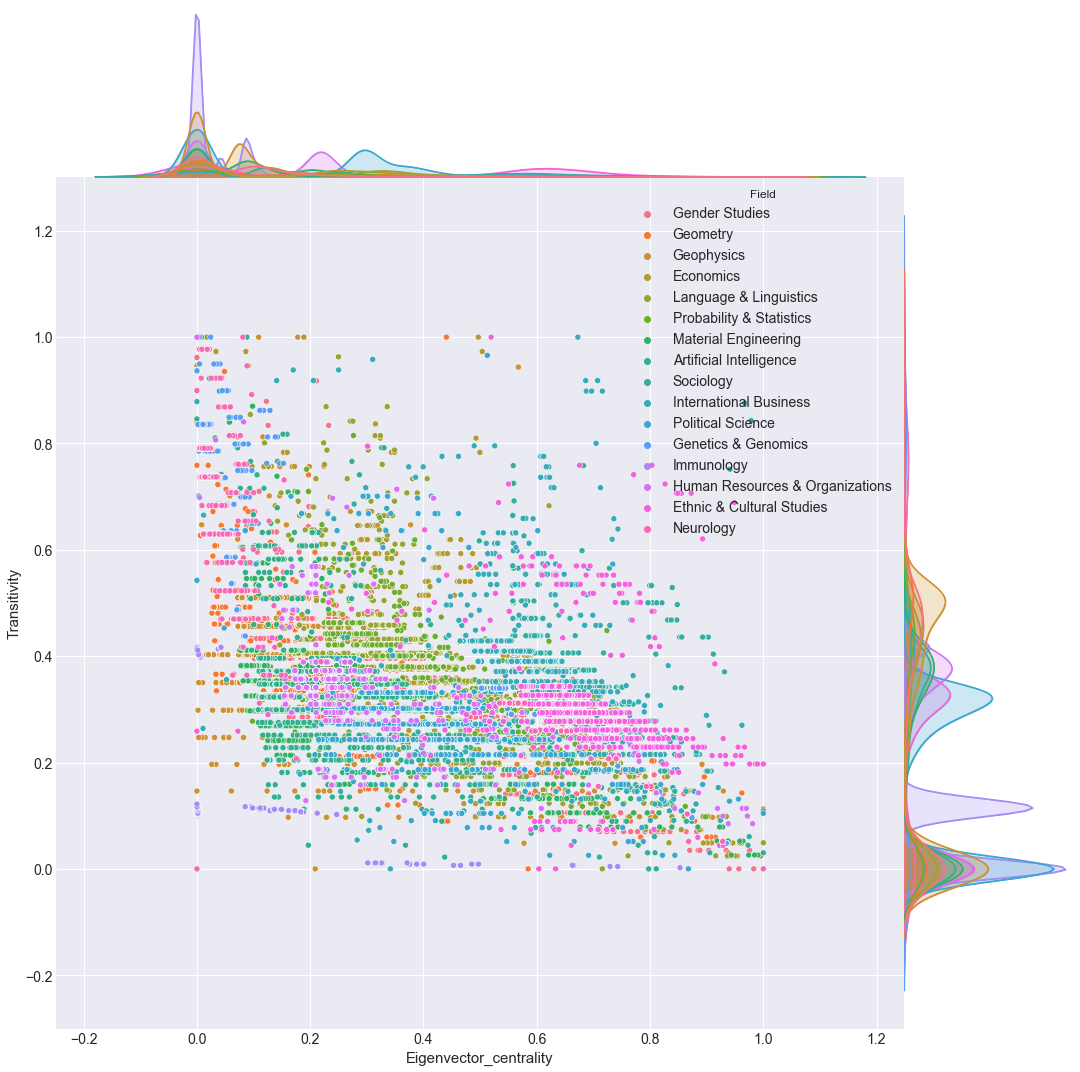

In [27]:
# sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

# fig, ax = plt.subplots(1)
jp = sns.jointplot(data=df, x="Eigenvector_centrality", y="Transitivity", hue="Field", height=15, space=0)
jp.plot_marginals(sns.kdeplot)

jp.ax_marg_x.set_facecolor('w')
jp.ax_marg_y.set_facecolor('w')

# for col, ax in zip(cols, axs):
#     sns.stripplot(data=df.to_pandas(), x=col, y="Field", ax=ax)
jp.ax.spines['top'].set_color('k')
jp.spines['top'].set_linewidth(1)
jp.spines['bottom'].set_color('k')
jp.spines['bottom'].set_linewidth(1)
jp.spines['right'].set_color('k')
jp.spines['right'].set_linewidth(1)
jp.spines['left'].set_color('k')
jp.spines['left'].set_linewidth(1)

plt.show()

# Embedding 

In [31]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

In [32]:
traces_path = os.path.join(OUTPUT_PATH, f'co_citation_traces')

co_citation_coef = []

for file in os.listdir(traces_path):

    field_name = file.split('.')[0]
    trace = az.from_netcdf(os.path.join(traces_path, file))

    summary = az.summary(trace, kind="stats")
    summary.index.name = 'beta'
    df = pl.from_pandas(summary, include_index=True)
    df = df.with_columns(pl.col('beta').str.replace('_', ' '))

    df = (
        df
        .with_columns((pl.col('mean') / pl.col('sd')).round(4).alias('z_score'))
        .with_columns((pl.col('z_score').abs().apply(norm.sf).round(4).alias('p_value')))
    )

    df_coef = (
        df.select(
            pl.col('beta'),
            pl.when(pl.col('p_value') > 0.05).then(0).otherwise(pl.col('mean')).alias(field_name)
        )
    )

    co_citation_coef.append(df_coef)

iter_dfs = iter(co_citation_coef)
co_citation_df_coef = next(iter_dfs)
for df in iter_dfs:
    co_citation_df_coef = co_citation_df_coef.join(df, on='beta', how='inner')

columns = co_citation_df_coef['beta'].to_list()
vec_df = co_citation_df_coef.select(pl.all().exclude('beta')).transpose(include_header=True, header_name='Field', column_names=columns)
field_names = vec_df['Field'].to_list()
vecs = vec_df.select(pl.all().exclude('Field')).to_numpy()

scaled_data = StandardScaler().fit_transform(vecs)

[]

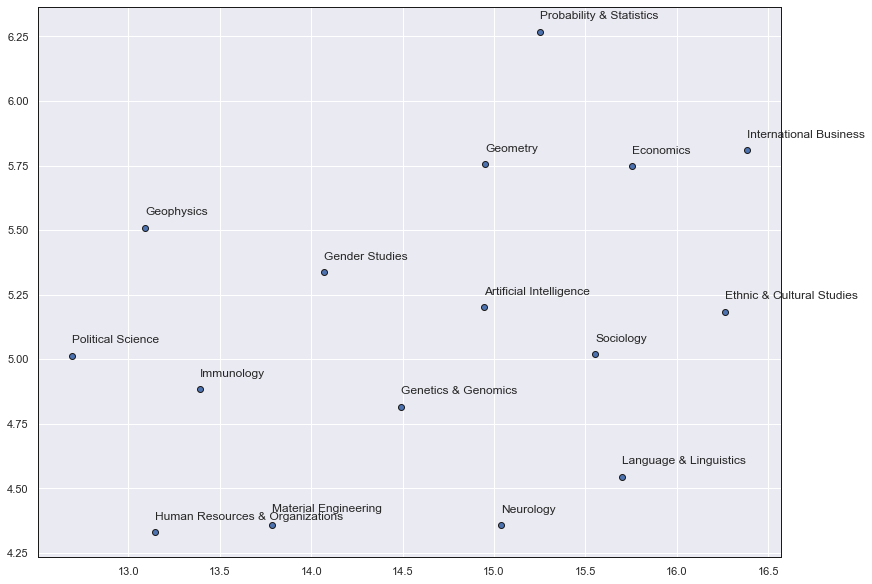

In [33]:
reducer = umap.UMAP(random_state=42)
embs = reducer.fit_transform(scaled_data)

sns.set()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

plt.scatter(embs[:, 0], embs[:, 1], alpha=1, edgecolor='k')

# ax.set_title(f'{field_name.capitalize()}', fontweight='semibold', fontsize=20)

for field_name, (x, y) in zip(field_names, embs):
    plt.text(x, y+0.05, field_name)


ax.spines['top'].set_color('k')
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_color('k')
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(1)

# fig.tight_layout()
# plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_citation_umap_node2vec.png')
plt.plot()